[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PTB-MR/mrpro/blob/main/examples/notebooks/comparison_trajectory_calculators.ipynb) [![Download notebook](https://img.shields.io/badge/Download-notebook-blue?logo=jupyter)](path:comparison_trajectory_calculators.ipynb)

In [1]:
import importlib

if not importlib.util.find_spec('mrpro'):
    %pip install mrpro[notebook]

# Different ways to obtain the trajectory
This example builds upon the <project:direct_reconstruction.ipynb> example and demonstrates three ways
to obtain the trajectory information required for image reconstruction:
- using the trajectory that is stored in the ISMRMRD file
- calculating the trajectory using the radial 2D trajectory calculator
- calculating the trajectory from the pulseq sequence file using the PyPulseq trajectory calculator

In [2]:
# Download raw data from Zenodo
import tempfile
from pathlib import Path

import mrpro
import torch
import zenodo_get

dataset = '14617082'

tmp = tempfile.TemporaryDirectory()  # RAII, automatically cleaned up
data_folder = Path(tmp.name)
zenodo_get.zenodo_get([dataset, '-r', 5, '-o', data_folder])  # r: retries

Title: 2D Radial MR raw data and Pulseq sequences
Keywords: 
Publication date: 2025-01-08
DOI: 10.5281/zenodo.14617082
Total size: 18.7 MB

Link: https://zenodo.org/records/14617082/files/radial2D_24spokes_golden_angle_with_traj.h5   size: 858.7 kB



Checksum is correct. (9a82b5f9c6f27a3db64fd8f7be65cfa3)

Link: https://zenodo.org/records/14617082/files/radial2D_24spokes_golden_angle.seq   size: 29.3 kB



Checksum is correct. (d48ba3340d511a7e24dfc69031a3b6ac)

Link: https://zenodo.org/records/14617082/files/radial2D_402spokes_golden_angle.seq   size: 172.2 kB



Checksum is correct. (ff682e21d7d2434dc5b672523dfeacec)

Link: https://zenodo.org/records/14617082/files/radial2D_96spokes_golden_angle_with_traj.h5   size: 3.4 MB



Checksum is correct. (9fc6d03790b1cf293cbd83939a1dd752)

Link: https://zenodo.org/records/14617082/files/radial2D_402spokes_golden_angle_with_traj.h5   size: 14.2 MB



Checksum is correct. (54d083c0040d3674317006cbaaa95420)

Link: https://zenodo.org/records/14617082/files/radial2D_96spokes_golden_angle.seq   size: 55.9 kB



Checksum is correct. (449434bf7b5e609d09cf5d42cf27c7f3)
All files have been downloaded.


### Using KTrajectoryIsmrmrd - Trajectory saved in ISMRMRD file
Passing an instance of `~mrpro.data.traj_calculators.KTrajectoryIsmrmrd` to
when loading the data tells the `~mrpro.data.KData` object to use the trajectory
that is stored in the ISMRMRD file.
```{note}
Often the trajectory information has not been stored in the ISMRMRD file,
in which case loading the trajectory this way will raise an error.
```

In [3]:
# Read the raw data and the trajectory from ISMRMRD file
kdata = mrpro.data.KData.from_file(
    data_folder / 'radial2D_402spokes_golden_angle_with_traj.h5',
    mrpro.data.traj_calculators.KTrajectoryIsmrmrd(),
)

# Reconstruct image
reconstruction = mrpro.algorithms.reconstruction.DirectReconstruction(kdata)
img_using_ismrmrd_traj = reconstruction(kdata)

### Using KTrajectoryRadial2D - Specific trajectory calculator
For some common trajectories, we provide specific trajectory calculators.
These calculators often require only a few parameters to be specified,
such as the angle between spokes in the radial trajectory. Other parameters
will be taken from the ISMRMRD file.
This will calculate the trajectory using the radial 2D trajectory calculator.
```{note}
You can also implement your own trajectory calculator by subclassing
`~mrpro.data.traj_calculators.KTrajectoryCalculator`.
```

In [4]:
# Read raw data and calculate trajectory using KTrajectoryRadial2D
golden_angle = torch.pi * 0.618034
kdata = mrpro.data.KData.from_file(
    data_folder / 'radial2D_402spokes_golden_angle_with_traj.h5',
    mrpro.data.traj_calculators.KTrajectoryRadial2D(golden_angle),
)

# Reconstruct image
reconstruction = mrpro.algorithms.reconstruction.DirectReconstruction(kdata)
img_using_rad2d_traj = reconstruction(kdata)

### Using KTrajectoryPulseq - Trajectory from pulseq sequence file
This will calculate the trajectory from the pulseq sequence file
using the PyPulseq trajectory calculator. This method
requires the pulseq sequence file that was used to acquire the data.
The path to the sequence file is provided as an argument to KTrajectoryPulseq.

In [5]:
# Read raw data and calculate trajectory using KTrajectoryPulseq
seq_path = data_folder / 'radial2D_402spokes_golden_angle.seq'
kdata = mrpro.data.KData.from_file(
    data_folder / 'radial2D_402spokes_golden_angle_with_traj.h5',
    mrpro.data.traj_calculators.KTrajectoryPulseq(seq_path),
)

# Reconstruct image
reconstruction = mrpro.algorithms.reconstruction.DirectReconstruction(kdata)
img_using_pulseq_traj = reconstruction(kdata)

### Plot the different reconstructed images
All three images are reconstructed using the same raw data and should look almost identical.

In [6]:
import matplotlib.pyplot as plt
import torch


def show_images(*images: torch.Tensor, titles: list[str] | None = None) -> None:
    """Plot images."""
    n_images = len(images)
    _, axes = plt.subplots(1, n_images, squeeze=False, figsize=(n_images * 3, 3))
    for i in range(n_images):
        axes[0][i].imshow(images[i], cmap='gray')
        axes[0][i].axis('off')
        if titles:
            axes[0][i].set_title(titles[i])
    plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  x = np.array(x, subok=True, copy=copy)


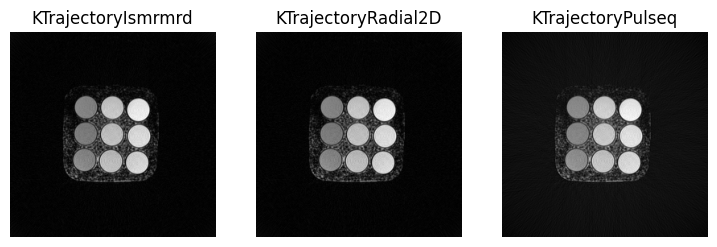

In [7]:
show_images(
    img_using_ismrmrd_traj.rss()[0, 0],
    img_using_rad2d_traj.rss()[0, 0],
    img_using_pulseq_traj.rss()[0, 0],
    titles=['KTrajectoryIsmrmrd', 'KTrajectoryRadial2D', 'KTrajectoryPulseq'],
)

Tada! We have successfully reconstructed images using three different trajectory calculators.
```{note}
Which of these three methods is the best depends on the specific use case:
If a trajectory is already stored in the ISMRMRD file, it is the most convenient to use.
If a pulseq sequence file is available, the trajectory can be calculated using the PyPulseq trajectory calculator.
Otherwise, a trajectory calculator needs to be implemented for the specific trajectory used.
```